<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

2024-04-21 15:00:17.869524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 15:00:17.869657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 15:00:17.992524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = "../input/emotion-detection-fer/train"
test_dir = "../input/emotion-detection-fer/test"

SEED = 125
IMG_HEIGHT = 139
IMG_WIDTH = 139
BATCH_SIZE = 64
EPOCHS = 20
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
preprocess_fun = tf.keras.applications.inception_v3.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 125
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 125
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 125
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Images with different emotions

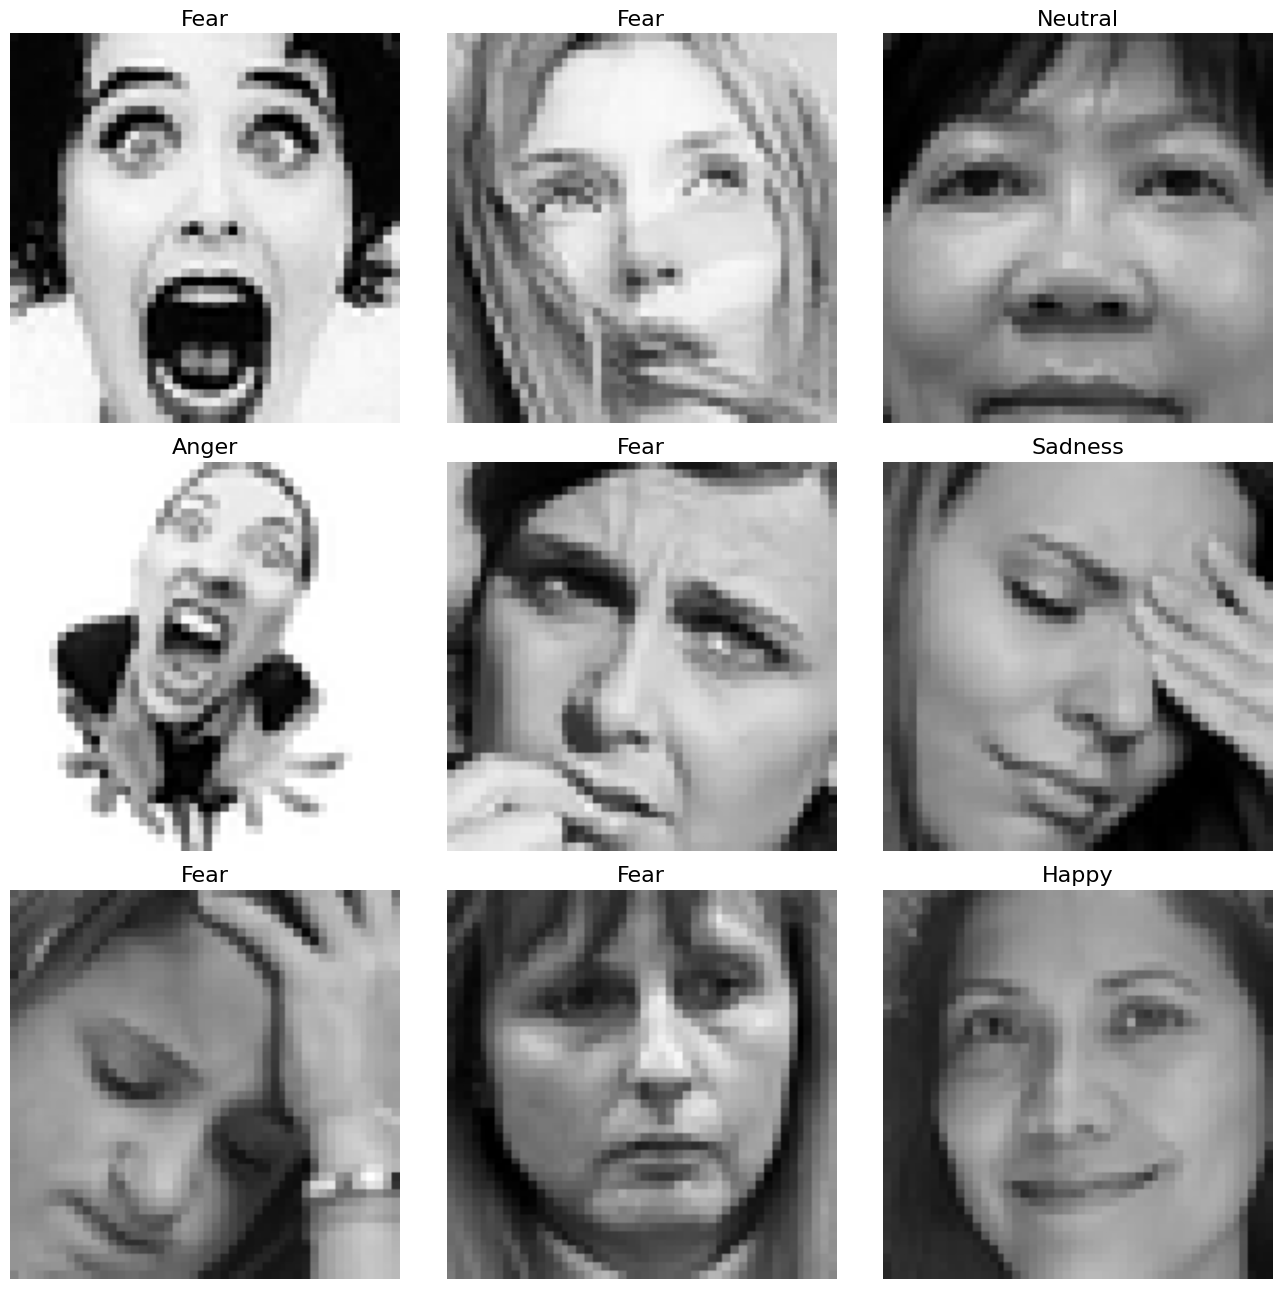

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 125
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [5]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> InceptionV3 Transfer Learning  </center>

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    # x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    # x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    # x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 139, 139, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,135 (91.20 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of InceptionV3

In [8]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/20
  1/359 ━━━━━━━━━━━━━━━━━━━━ 2:11:07 22s/step - accuracy: 0.1406 - loss: 2.0159

I0000 00:00:1713711682.702207     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 259s 662ms/step - accuracy: 0.2327 - loss: 1.8378 - val_accuracy: 0.2893 - val_loss: 1.7459
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 310ms/step - accuracy: 0.2697 - loss: 1.7729 - val_accuracy: 0.3146 - val_loss: 1.7352
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 112s 308ms/step - accuracy: 0.2844 - loss: 1.7496 - val_accuracy: 0.3426 - val_loss: 1.6993
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 312ms/step - accuracy: 0.2932 - loss: 1.7278 - val_accuracy: 0.3041 - val_loss: 1.7219
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 308ms/step - accuracy: 0.3039 - loss: 1.7244 - val_accuracy: 0.3182 - val_loss: 1.6824
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 112s 307ms/step - accuracy: 0.3160 - loss: 1.7077 - val_accuracy: 0.3329 - val_loss: 1.6616
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 310ms/step - accuracy: 0.3203 - loss: 1.6948 - val_accuracy: 0.3465 - val_loss: 1.6607
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 311ms/step - accuracy: 0.3167 - loss: 1.70

## Fine Tuning

In [9]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 207s 429ms/step - accuracy: 0.2561 - loss: 1.9048 - val_accuracy: 0.2007 - val_loss: 4.0558
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 313ms/step - accuracy: 0.3868 - loss: 1.5586 - val_accuracy: 0.4119 - val_loss: 1.5509
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 143s 316ms/step - accuracy: 0.4296 - loss: 1.4787 - val_accuracy: 0.4599 - val_loss: 1.4475
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 317ms/step - accuracy: 0.4599 - loss: 1.4072 - val_accuracy: 0.4715 - val_loss: 1.3912
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 318ms/step - accuracy: 0.4780 - loss: 1.3679 - val_accuracy: 0.4919 - val_loss: 1.3586
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 313ms/step - accuracy: 0.4989 - loss: 1.3195 - val_accuracy: 0.4976 - val_loss: 1.3288
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 318ms/step - accuracy: 0.5086 - loss: 1.2882 - val_accuracy: 0.5109 - val_loss: 1.3029
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 117s 321ms/step - accuracy: 0.5250 -

## Training plots

In [10]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [11]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [12]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.4951 - loss: 1.3092
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step


## Confusion Matrix

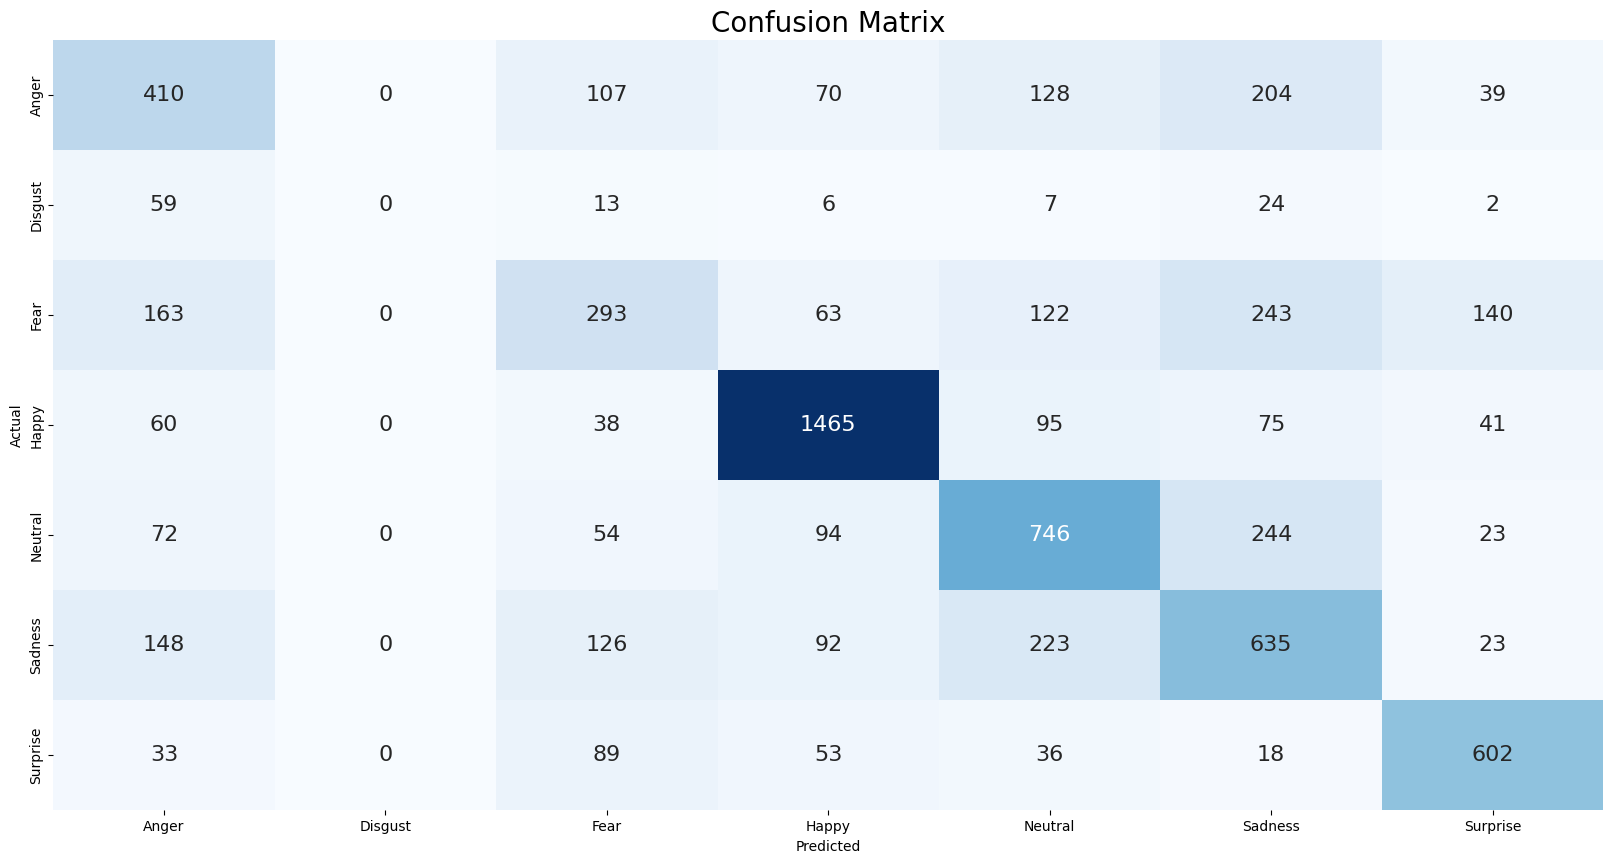

In [13]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [14]:
# 'Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43       958
           1       0.00      0.00      0.00       111
           2       0.41      0.29      0.34      1024
           3       0.79      0.83      0.81      1774
           4       0.55      0.61      0.58      1233
           5       0.44      0.51      0.47      1247
           6       0.69      0.72      0.71       831

    accuracy                           0.58      7178
   macro avg       0.47      0.48      0.48      7178
weighted avg       0.56      0.58      0.57      7178



## Multiclass AUC Curve

ROC AUC score: 0.8937587954696717


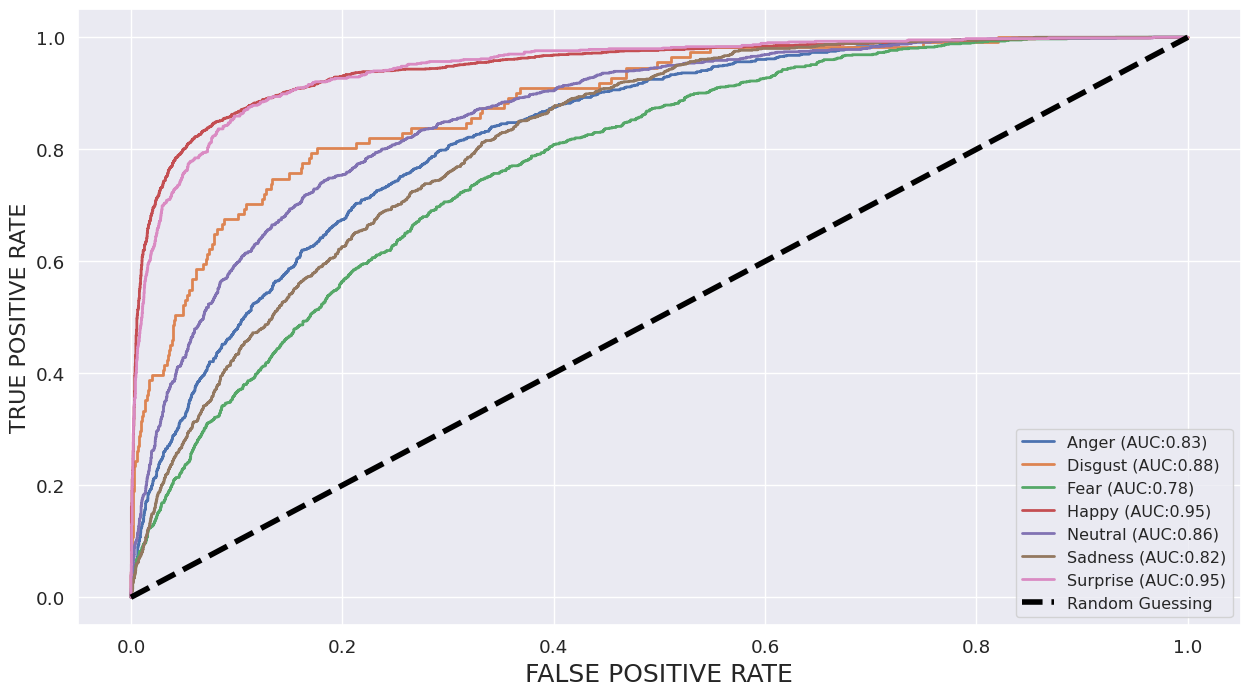

In [15]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [16]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8655901750009249


In [17]:
# !rm -rf /kaggle/working/InceptionV3_Ver1.h5
!rm -rf /kaggle/working/logs

In [18]:
model.save("/kaggle/working/InceptionV3.keras")

In [19]:
# It can be used to reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("/kaggle/working/InceptionV3.keras")

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.evaluate(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.4951 - loss: 1.3092


[1.1371954679489136, 0.5782948136329651]

In [20]:
model.evaluate(test_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.4951 - loss: 1.3092


[1.1371954679489136, 0.5782948136329651]

# **RESNET 50**

In [21]:
def feature_extractor_1(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                       include_top=False,
                                                       weights="imagenet")(inputs)
    
    return feature_extractor

def classifier_1(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model_1(inputs):
    resnet_feature_extractor = feature_extractor_1(inputs)
    classification_output = classifier_1(resnet_feature_extractor)
    
    return classification_output

def define_compile_model_1():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model_1(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
  
    return model


In [22]:
model_1 = define_compile_model()
clear_output()

# Freezing the feature extraction layers
model_1.layers[1].trainable = False

model_1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 139, 139, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,135 (91.20 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
history_1 = model_1.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history_1 = pd.DataFrame(history_1.history)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 136s 345ms/step - accuracy: 0.2372 - loss: 1.8301 - val_accuracy: 0.3047 - val_loss: 1.7702
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 313ms/step - accuracy: 0.2739 - loss: 1.7691 - val_accuracy: 0.2808 - val_loss: 1.7359
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 313ms/step - accuracy: 0.2875 - loss: 1.7511 - val_accuracy: 0.2547 - val_loss: 1.7762
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 314ms/step - accuracy: 0.3034 - loss: 1.7280 - val_accuracy: 0.3144 - val_loss: 1.7024
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 316ms/step - accuracy: 0.3000 - loss: 1.7258 - val_accuracy: 0.3144 - val_loss: 1.6922
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 313ms/step - accuracy: 0.3068 - loss: 1.7150 - val_accuracy: 0.3343 - val_loss: 1.6654
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 114s 311ms/step - accuracy: 0.3175 - loss: 1.6967 - val_accuracy: 0.3141 - val_loss: 1.7209
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 314ms/step - accuracy: 0.3267 -

In [24]:
# Un-Freezing the feature extraction layers for fine tuning 
model_1.layers[1].trainable = True

model_1.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_11 = model_1.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history_1 = pd.concat([history_1, pd.DataFrame(history_11.history)], ignore_index=True)

Epoch 1/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 184s 397ms/step - accuracy: 0.2435 - loss: 1.8834 - val_accuracy: 0.1596 - val_loss: 2.5803
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 153s 320ms/step - accuracy: 0.3780 - loss: 1.5794 - val_accuracy: 0.3937 - val_loss: 1.5688
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 323ms/step - accuracy: 0.4275 - loss: 1.4882 - val_accuracy: 0.4379 - val_loss: 1.4661
Epoch 4/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 117s 320ms/step - accuracy: 0.4553 - loss: 1.4193 - val_accuracy: 0.4585 - val_loss: 1.4168
Epoch 5/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 321ms/step - accuracy: 0.4751 - loss: 1.3700 - val_accuracy: 0.4794 - val_loss: 1.3747
Epoch 6/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 119s 324ms/step - accuracy: 0.4963 - loss: 1.3358 - val_accuracy: 0.4950 - val_loss: 1.3338
Epoch 7/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 322ms/step - accuracy: 0.5049 - loss: 1.2993 - val_accuracy: 0.5079 - val_loss: 1.2977
Epoch 8/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 118s 321ms/step - accuracy: 0.5224 -

In [25]:
x = px.line(data_frame= history_1 , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [26]:
x = px.line(data_frame= history_1 , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [27]:
model_1.evaluate(test_generator)
preds = model_1.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.4945 - loss: 1.3030
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step


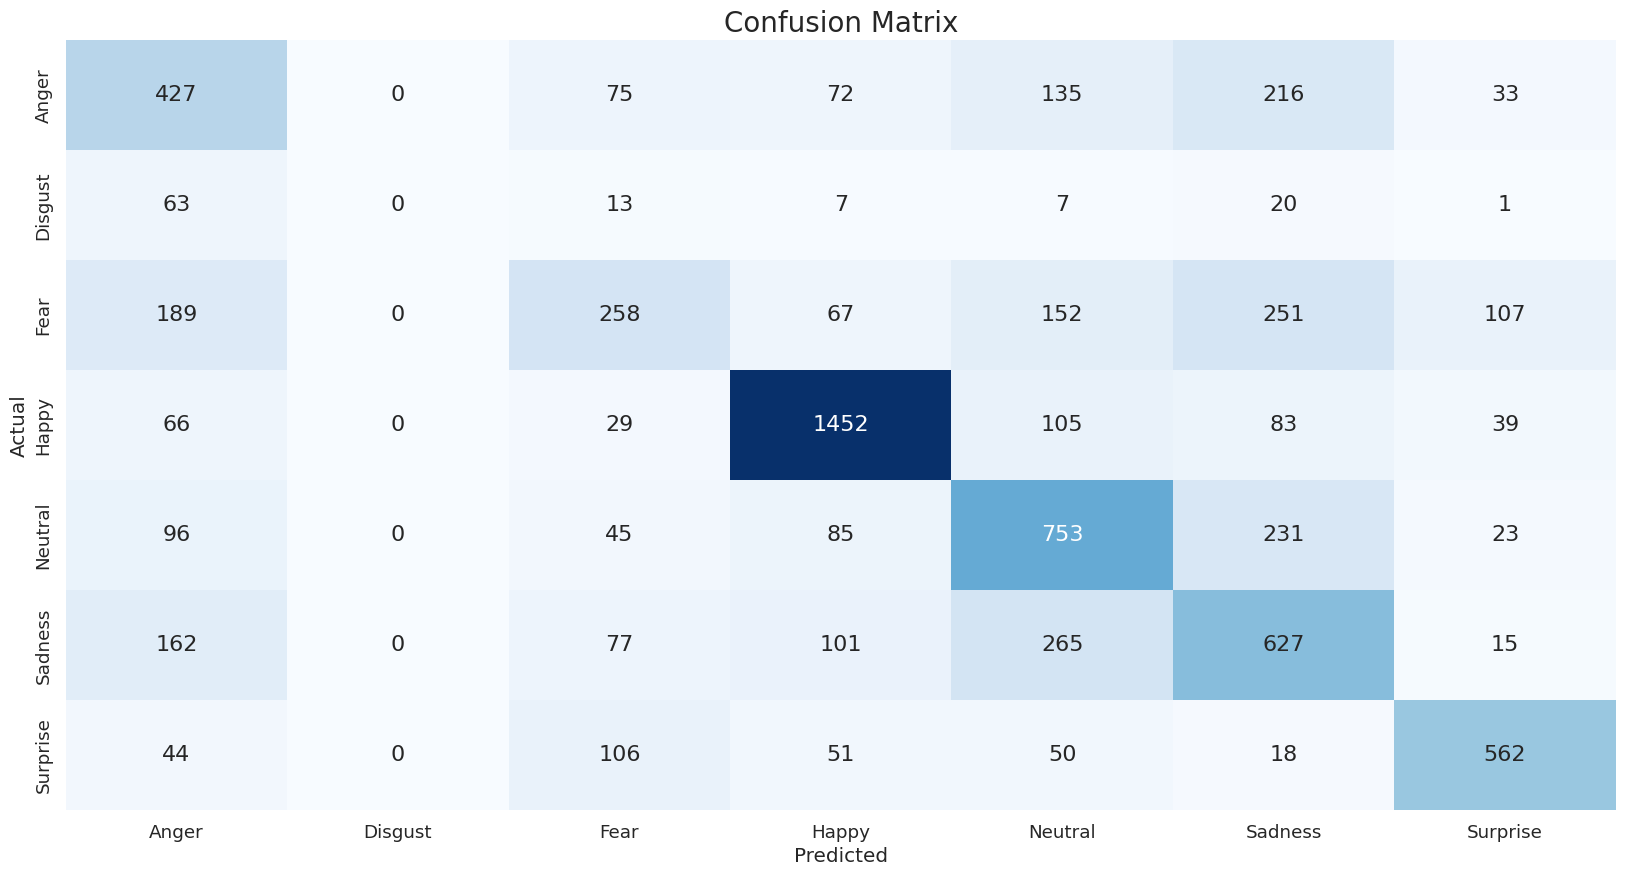

In [28]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [29]:
# 'Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43       958
           1       0.00      0.00      0.00       111
           2       0.43      0.25      0.32      1024
           3       0.79      0.82      0.80      1774
           4       0.51      0.61      0.56      1233
           5       0.43      0.50      0.47      1247
           6       0.72      0.68      0.70       831

    accuracy                           0.57      7178
   macro avg       0.47      0.47      0.47      7178
weighted avg       0.56      0.57      0.56      7178



ROC AUC score: 0.889456424544487


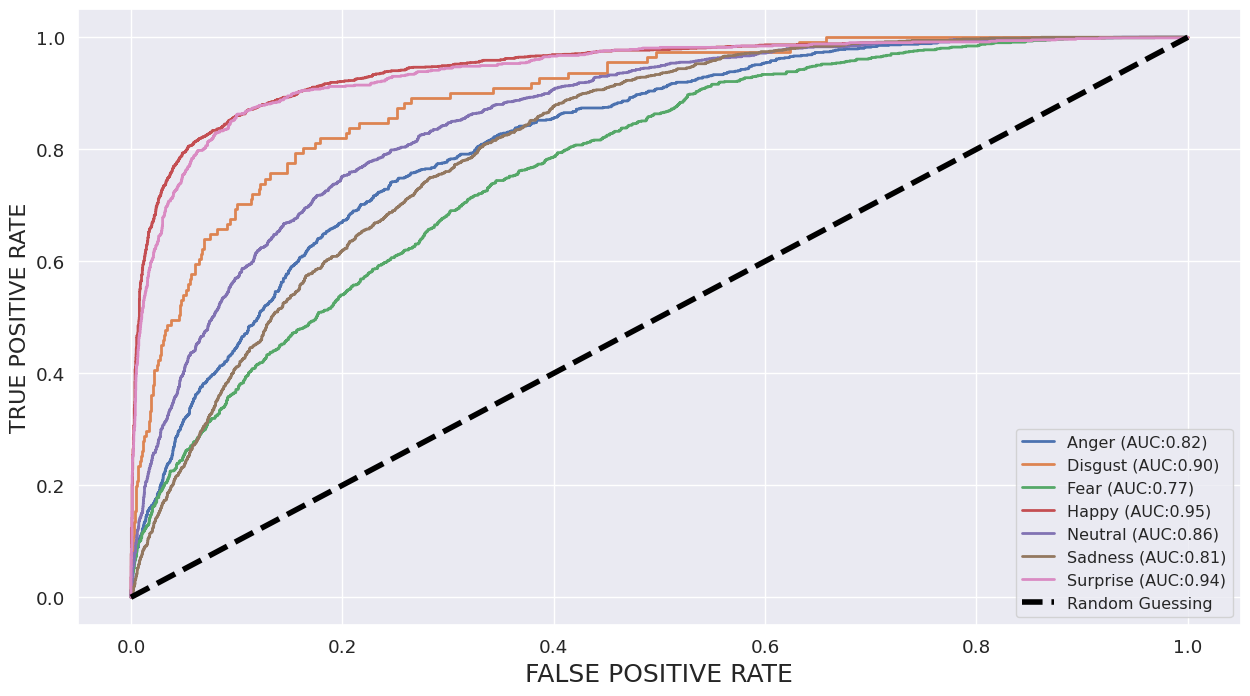

In [30]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [31]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8628498390293216


In [32]:
!rm -rf /kaggle/working/logs
model.save("/kaggle/working/ResNetV50.keras")